# Training a Classifier on Perturbed $\gamma$ & $\gamma^\prime$ Crystals using GMMs and Decomposition

This tutorial describes how to set up a database of crystals using the `ase` package and __rattling__. Rattling is the perturbation of crystals away from their highest symmetry configuration using some displacement distribution. Rattling thus emulates the effect of temperature without the expansion of the lattice. The atoms of the rattled crystals are then each transformed into feature vectors for classification. Classification is here carried out using a modified form of Gaussian Mixture Models (GMMs). Lastly, the classifier is evaluated for the different phases selected.

Particular to this tutorial is that instead of directly using GMMs from rattling trajectories (the same crystal rattled a few times) for classification we instead compare the obtained GMMs and deduce underlying density distributions. This is done by _decomposing_ the obtained GMMs via comparison. This is useful in cases where one crystal may contain more than one kind of physical feature, e.g. a crystal defect, allowing to generate a class for that physical feature as well as the general crystal type.

In [1]:
%matplotlib notebook
import numpy as np
from scipy import interpolate, spatial, stats, special, optimize
import itertools, warnings, copy
from ase.lattice.cubic import FaceCenteredCubic, SimpleCubicFactory
from ase.spacegroup import crystal
from ase.build import nanotube, graphene_nanoribbon
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model, utils, preprocessing
import sklearn
import atomtoolbox as atb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

E:\Programs\Anaconda3\envs\py35\lib\site-packages\ase\lattice\spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


## 1. Generating a Collection of Ideal Crystals

In [2]:
a0 = 3.52
L12 = atb.L12Factory()
size = np.array([5,5,5],dtype=int)

atoms_gamma_prime = L12(directions=[[1,0,0],[0,1,0],[0,0,1]], size=tuple(size),
                          symbol=["Al","Ni"],pbc=(1,1,1),latticeconstant=a0)
atoms_dict = {"gamma_prime":atoms_gamma_prime}

afccAl = 4.05
atoms_fccAl = crystal('Al', [(0,0,0)], spacegroup=225, cellpar=[afccAl, afccAl, afccAl, 90, 90, 90],
                     size=tuple(size), pbc=(1,1,1))
atoms_dict["Al"] = atoms_fccAl

afccNi = 3.57
atoms_fccNi = crystal('Ni', [(0,0,0)], spacegroup=225, cellpar=[afccNi, afccNi, afccNi, 90, 90, 90],
                     size=tuple(size), pbc=(1,1,1))
atoms_dict["Ni"] = atoms_fccNi

Ngamma = 1
concentrations_list = [{"Al":.2},]
lattice_c = lambda c: (1.-c)*afccNi + c*afccAl

for i in range(Ngamma):
    for concentrations in concentrations_list:
        a = lattice_c(concentrations["Al"]/100.)
        
        atoms_gamma = crystal('Ni', [(0,0,0)], spacegroup=225, cellpar=[a, a, a, 90, 90, 90],
                     size=tuple(size), pbc=(1,1,1))

        atoms_gamma = atb.create_chemical_disorder(atoms_gamma,concentrations)
        atoms_dict["gamma{}Al#{}".format(concentrations["Al"],i)] = atoms_gamma

## 2. Rattling Crystals

In [3]:
Nrattle = 5
rattle_rvs = [stats.norm(loc=0,scale=.001), stats.norm(loc=0,scale=.005),
              stats.norm(loc=0,scale=.01), stats.norm(loc=0,scale=.02),]#\
#                stats.norm(loc=0,scale=.03), stats.norm(loc=0,scale=.05),
#                 stats.norm(loc=0,scale=.1), stats.norm(loc=0,scale=.5)]
CRs = [atb.CrystalRattler(rattle_rv=rattle_rv) for rattle_rv in rattle_rvs]

rpositions, Natoms, cells, species = None, None, None, None
crystal_names = []
all_rattled_positions = dict()
t_l = []
for sname in sorted(atoms_dict):
    print("rattling ",sname)
    rpositions, Natoms, cells, species = atb.rattle_crystal_multiple_rvs(Nrattle, rattle_rvs,\
                                atoms_dict[sname], rpositions=rpositions, Natoms=Natoms,\
                                species=species, cells=cells)
    t_l.append([sname for v in range(Nrattle*len(rattle_rvs)*atoms_dict[sname].positions.shape[0])])
    crystal_names.extend([sname for v in range(Nrattle*len(rattle_rvs))])
    
rpositions_flat, Natoms_flat, cells_flat, species_flat = atb.flattening_rattled_crystal_data(rpositions,\
                                                    Natoms, cells, species)
t_l_flat = np.hstack(t_l)
print("t_l_flat {}".format(len(t_l_flat)))
print("rpositions_flat {}, Natoms_flat {} atoms total {}, cells_flat {}, species_flat {}".format(len(rpositions_flat), len(Natoms_flat), sum(Natoms_flat), len(cells_flat), len(species_flat)))

rattling  Al
rattling  Ni
rattling  gamma0.2Al#0
rattling  gamma_prime
t_l_flat 40000
rpositions_flat 80, Natoms_flat 80 atoms total 40000, cells_flat 80, species_flat 80


## 3. Setting up Design Matrices

In [4]:
all_filter = lambda s,s_ref: np.array([True for v in range(s.shape[0])])
like_filter = lambda s,s_ref: s == s_ref
unlike_filter = lambda s,s_ref: s != s_ref

## Neighbourhood search conditions 
# Note that r_cut is currently required for the ultracell generation as well as neighbourhood search.
# If num_neigh is not equal to None then num_neigh takes precedence in the nelghbourhood search
# over r_cut. r_cut then needs to be sufficiently large to provide the adequate amount of neighbours.
r_cut = 6. 
num_neigh = 18

## feature parameters
tbaf_params = {"k":20,"_range":(0,np.pi),"normed":True,"element_filter":all_filter}
bopf_params = {"k":[4,6],"element_filter":all_filter,"kind":"3"}
bopf_params_like = {"k":[4,6],"element_filter":like_filter,"kind":"3"}
bopf_params_unlike = {"k":[4,6],"element_filter":unlike_filter,"kind":"3"}
count_params = {"elements":sorted(["Al","Ni"]), "normed":True}

featurers = [atb.BondOrderParameterFeatures,
             atb.BondOrderParameterFeatures,
             atb.ElementCountFeatures]#,atb.BondOrderParameterFeatures]
#             atb.BondOrderParameterFeatures,atb.ElementCountFeatures]
featurer_params = [bopf_params_like, bopf_params_unlike, count_params]

all_Phis = []
for i in range(len(rpositions_flat)): # looping rattle rv & crystal type
    if i%10==0:
        print("\n{}/{}".format(i+1,len(rpositions_flat)))
    print("crystal ",crystal_names[i])
    _pos = rpositions_flat[i]
    _cell = cells_flat[i]
    _spec = species_flat[i]

    _Phi, mapper = atb.get_crystal_design_matrix(positions=_pos, species=_spec, cell=_cell, r_cut=r_cut, 
                                    num_neigh=num_neigh,
                                    features_class=featurers, params_features=featurer_params, 
                                    return_force=False, return_mapper=True)
    
    assert np.isfinite(_Phi).all(), "_Phi contains non-finite values."
    if i == 0:
        Phi = np.copy(_Phi)
    else:
        Phi = np.vstack((Phi,_Phi))
    print("Phi ",Phi.shape)
    all_Phis.append(_Phi)


1/80
crystal  Al
Phi  (500, 6)
crystal  Al
Phi  (1000, 6)
crystal  Al
Phi  (1500, 6)
crystal  Al
Phi  (2000, 6)
crystal  Al
Phi  (2500, 6)
crystal  Al
Phi  (3000, 6)
crystal  Al
Phi  (3500, 6)
crystal  Al
Phi  (4000, 6)
crystal  Al
Phi  (4500, 6)
crystal  Al
Phi  (5000, 6)

11/80
crystal  Al
Phi  (5500, 6)
crystal  Al
Phi  (6000, 6)
crystal  Al
Phi  (6500, 6)
crystal  Al
Phi  (7000, 6)
crystal  Al
Phi  (7500, 6)
crystal  Al
Phi  (8000, 6)
crystal  Al
Phi  (8500, 6)
crystal  Al
Phi  (9000, 6)
crystal  Al
Phi  (9500, 6)
crystal  Al
Phi  (10000, 6)

21/80
crystal  Ni
Phi  (10500, 6)
crystal  Ni
Phi  (11000, 6)
crystal  Ni
Phi  (11500, 6)
crystal  Ni
Phi  (12000, 6)
crystal  Ni
Phi  (12500, 6)
crystal  Ni
Phi  (13000, 6)
crystal  Ni
Phi  (13500, 6)
crystal  Ni
Phi  (14000, 6)
crystal  Ni
Phi  (14500, 6)
crystal  Ni
Phi  (15000, 6)

31/80
crystal  Ni
Phi  (15500, 6)
crystal  Ni
Phi  (16000, 6)
crystal  Ni
Phi  (16500, 6)
crystal  Ni
Phi  (17000, 6)
crystal  Ni
Phi  (17500, 6)
crystal  Ni
P

## 4. Generating Labeling & Split into Test and Train Sets

In [5]:
label_map = dict()
    
# merge all samples from the same crystal type
t_l_flat = atb.assign_chemical_disorder_labels(atoms_dict, t_l_flat, Phi, mapper, species_flat, mapper_key=2,
                                    count_params=count_params)

# We only want to train on spherical harmonic features. Thus we choose Phi[:,:-2 ]
# below, ignoring the last two columns which contains info of element count features.
all_Phis = [Phi[t_l_flat==t,:-2] for t in np.unique(t_l_flat)] 

test_size = .4

all_Nsamples = [all_Phis[i].shape[0] for i in range(len(all_Phis))]
idx_all_train = [np.random.choice(np.arange(_Nsamples),size=int(_Nsamples*(1-test_size)), 
                                  replace=False) for _Nsamples in all_Nsamples]
idx_all_test = [np.setdiff1d(np.arange(_Nsamples),_idx_all_train) for _Nsamples, _idx_all_train in zip(all_Nsamples, idx_all_train)]

all_Phis_train = [_Phis[_idx_train,:] for _Phis, _idx_train in zip(all_Phis, idx_all_train)]
all_Phis_test = [_Phis[_idx_test,:] for _Phis, _idx_test in zip(all_Phis, idx_all_test)]

## 5. Plotting Things

<IPython.core.display.Javascript object>


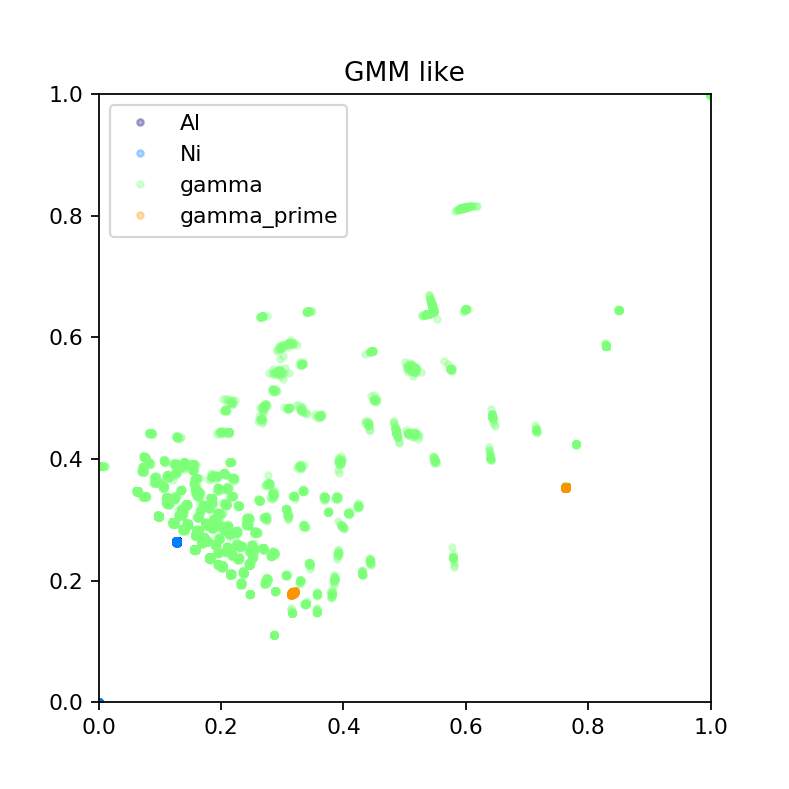

<IPython.core.display.Javascript object>


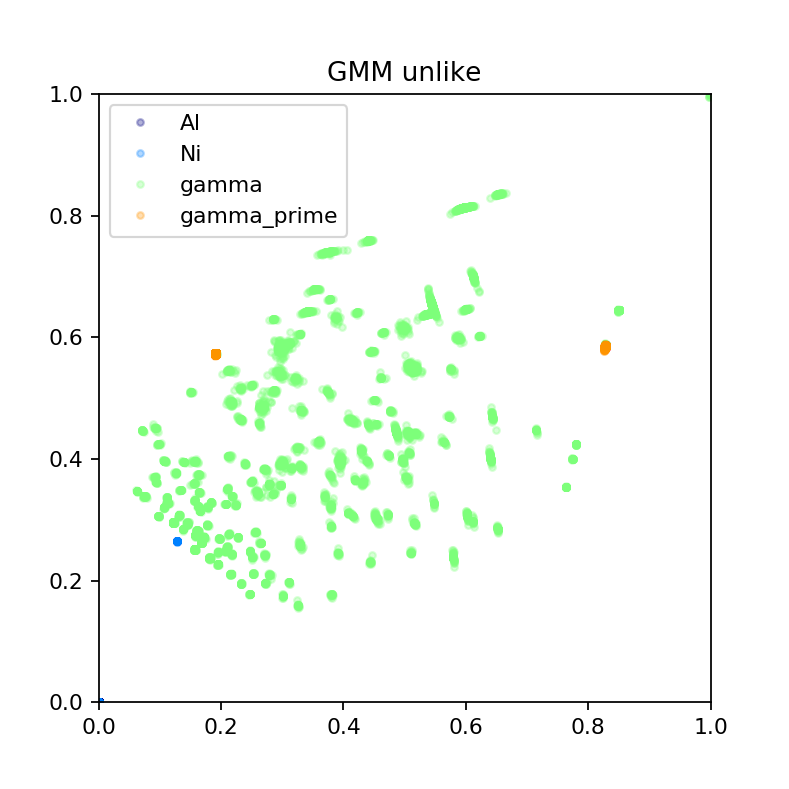

In [6]:
#idx_class = {k:np.where(t_train==k)[0] for k in np.unique(t_train)}

xlim, ylim = (0,1), (0,1)
x, y = np.linspace(xlim[0],xlim[1],1000), np.linspace(ylim[0],ylim[1],1000)
xgrid, ygrid = np.meshgrid(x,y,indexing="ij")
X_plot = np.array([xgrid.ravel(), ygrid.ravel()]).T
s = xgrid.shape

_labels = np.sort(np.unique(t_l_flat))
color_map = {k:i/float(_labels.shape[0]) for i,k in enumerate(_labels)}

# all
# fig = plt.figure(figsize=(5,5))
# ax = fig.add_subplot(111)

# _n = 0
# for i,X in enumerate(all_Phis):
    
#     ax.plot(X[:,0], X[:,1],'.',label=t_l_flat[_n],alpha=.3, color=plt.cm.jet(color_map[t_l_flat[_n]]))
#     _n += X.shape[0]
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
# ax.set_title("GMM all")
# plt.legend(loc=0)
# plt.show()

# like
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

_n = 0
for i,X in enumerate(all_Phis):
    
    ax.plot(X[:,0], X[:,1],'.',label=t_l_flat[_n],alpha=.3, color=plt.cm.jet(color_map[t_l_flat[_n]]))
    _n += X.shape[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("GMM like")
plt.legend(loc=0)
plt.show()


# unlike
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

_n = 0
for i,X in enumerate(all_Phis):
    
    ax.plot(X[:,2], X[:,3],'.',label=t_l_flat[_n],alpha=.3, color=plt.cm.jet(color_map[t_l_flat[_n]]))
    _n += X.shape[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("GMM unlike")
plt.legend(loc=0)
plt.show()

## 6. Gaussian Mixture Based Classification using Decomposition

Here we use a modification of GMMs for the induction of a classifier. For an example with various classifiers, standardization and test/train splits see: http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

### 6.1 Fit Gaussian Mixtures

Commonly GMM are used to approximate the complete distribution of all classes in feature space. The individual Gaussians are then related to the individual classes. Instead we approximate here the  feature space distribution for each class individually with a set of Gaussians. These approximations are then used to compare classes for a new position in feature space.

Decomposition means that each density distribution approximated via GMMs is compared against all other GMMs created inferring similarities and differences. The decomposition is carried out by the `BayesianGaussianMixture` class if and only if the given input for `fit` is a list of design matrices (note they all need to have the same number of features).

E:\Programs\Anaconda3\envs\py35\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


number of resulting models:  4
number of components in total:  36

E:\PetProjects\AtomToolBox\AtomToolBox_bitbucket\atomtoolbox\classification.py:133: RuntimeWarning: divide by zero encountered in log
  return - (np.log(np.dot(_g,wbound(w)))).sum()
E:\Programs\Anaconda3\envs\py35\lib\site-packages\scipy\optimize\optimize.py:528: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):
E:\PetProjects\AtomToolBox\AtomToolBox_bitbucket\atomtoolbox\classification.py:350: UserWarning: Weights were not optimized! Changes are smaller than 1e-06.
  warnings.warn("Weights were not optimized! Changes are smaller than {}.".format(self.tol0))


<IPython.core.display.Javascript object>


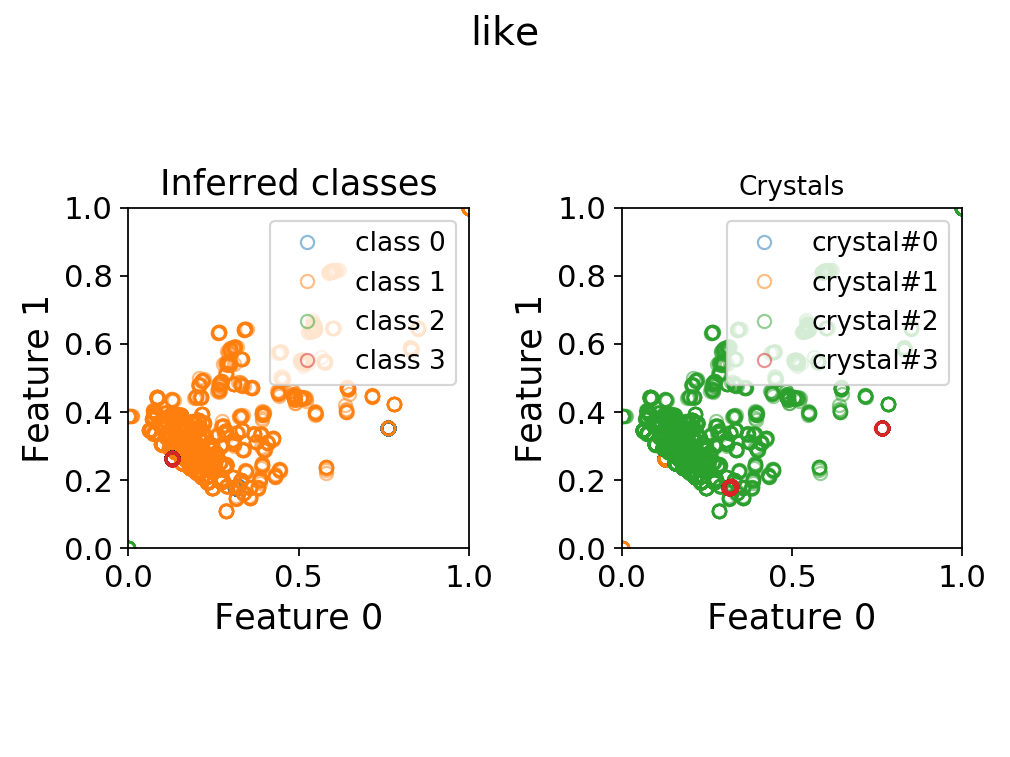

<IPython.core.display.Javascript object>


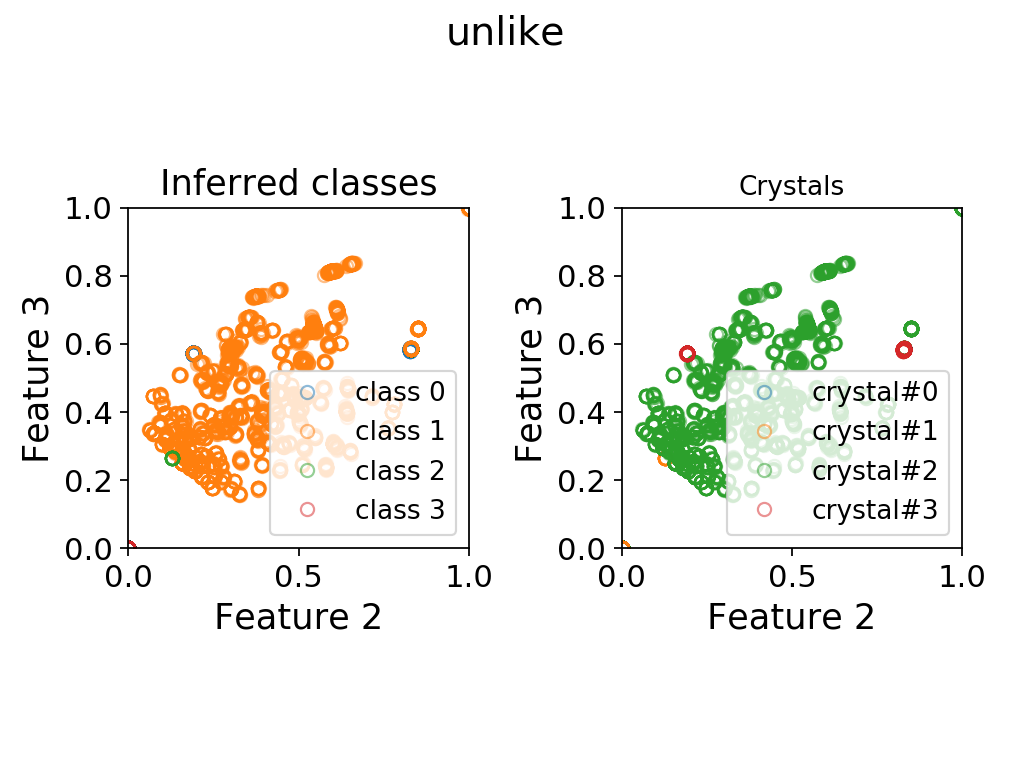

[array([2, 2, 3, ..., 2, 2, 2], dtype=int64),
 array([2, 2, 2, ..., 2, 2, 2], dtype=int64),
 array([1, 1, 1, ..., 1, 1, 1], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]

In [7]:
# choose mixture class
vgmm = BayesianGaussianMixture(n_components=25, weight_concentration_prior=1., 
                               covariance_type="full")
# initialize the classifier class with the chosen mixture class
gmc = atb.GaussianMixtureClassifier(gmm=vgmm, cluster={"method":"average","metric":"euclidean",
                       "threshold":1e-4,"criterion":"distance","cluster_parameters":"mu","combine":"mean"},
                 weights_fit_method="Nelder-Mead", verbose=True)
# fitting the mixtures for all observations
#gmc.fit(Phi_train, t_train, label_map=label_map)
gmc.fit(all_Phis_train, None, label_map=None)

# gmc.predict(all_Phis_train, show=True, axes=[0,1], title="all")
gmc.predict(all_Phis_train, show=True, show_kwargs=dict(axes=[0,1], title="like"))
gmc.predict(all_Phis_train, show=True, show_kwargs=dict(axes=[2,3], title="unlike"))

### 6.2 Store the Classifier (without a label map)

In [8]:
save_path = "BayesianGaussianMixtureClassifier_decomposed_Ni-Al.pckl"
gmc.save(save_path)

### 6.3 Load the Classifier

In [9]:
load_path = "BayesianGaussianMixtureClassifier_decomposed_Ni-Al.pckl"
gmc_load = atb.GaussianMixtureClassifier(load_path=load_path, check_labels=False)

### 6.4 Identify Labels

In [10]:
from ase.visualize import view

atoms = atoms_dict["Ni"]

_cell = atoms.get_cell()
_pos = atb.get_wrapped_positions(atoms.get_positions(wrap=True), _cell)
_spec = atoms.get_chemical_symbols()

_Phi = atb.get_crystal_design_matrix(positions=_pos, species=_spec, cell=_cell, r_cut=r_cut, 
                                num_neigh=num_neigh,
                                features_class=featurers, params_features=featurer_params, 
                                return_force=False, return_mapper=False)

y = gmc_load.predict(_Phi[:,:-2]) # the last two columns contain chemical species info which was ignore above
print("Predicted classes:",np.unique(y))

Predicted classes: [2]


In [11]:
c = 2 # classification to look at

# plot crystal with atoms identified as c in 3D
view(atoms[y==c])
plt.show()

### 6.5 Store Classifier (with a label map)

In [12]:
label_map = {"gamma_prime":0,"fcc":2,"distorted":1}
gmc_load.label_map = label_map

save_path = "BayesianGaussianMixtureClassifier_Ni-Al.pckl"
gmc_load.save(save_path)